In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [6]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [7]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

##Level_1
# layer 1
inputs1_1= Input(shape=(n_timesteps,n_features))##128,9
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1) ##none,126,128
# layer 2
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)##124,128
# layer 3
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)##122,128
# layer 4
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)##120,128

# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)

#maxpool1
pool_1=MaxPooling1D(pool_size=5)(merged_1)

In [8]:
flat_cnn=Flatten()(pool_1)

##dense layer
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

##MODEL
cnn3_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn3_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 128)  │      3,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 124, 128)  │      5,888 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 122, 128)  │      8,192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 120, 128)  │     10,496 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 492, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 98, 128)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  6,423,040 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │      3,078 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,454,278 (24.62 MB)

 Trainable params: 6,454,278 (24.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_history=cnn3_model.fit(x=[X_train,X_train,X_train,X_train], y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.7380 - loss: 0.9107 - val_accuracy: 0.9491 - val_loss: 0.1271
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.9539 - loss: 0.1146 - val_accuracy: 0.9457 - val_loss: 0.1388
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.9509 - loss: 0.1172 - val_accuracy: 0.9559 - val_loss: 0.1163
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9514 - loss: 0.1270 - val_accuracy: 0.9474 - val_loss: 0.1042
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9558 - loss: 0.1008 - val_accuracy: 0.9576 - val_loss: 0.0942
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9594 - loss: 0.0934 - val_accuracy: 0.9576 - val_loss: 0.0948
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.9594 - loss: 0.0914 - val_accuracy: 0.9508 - val_loss: 0.0872
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9608 - loss: 0

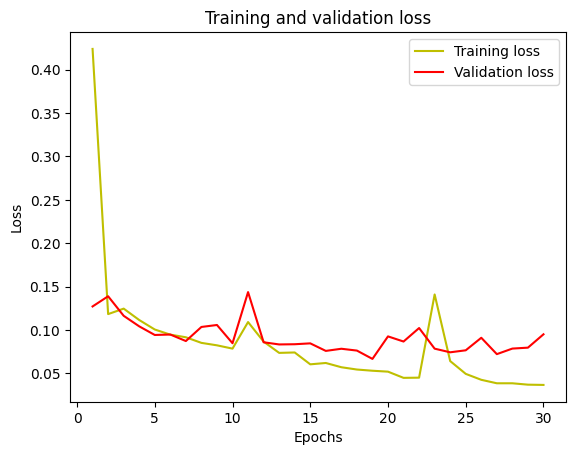

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


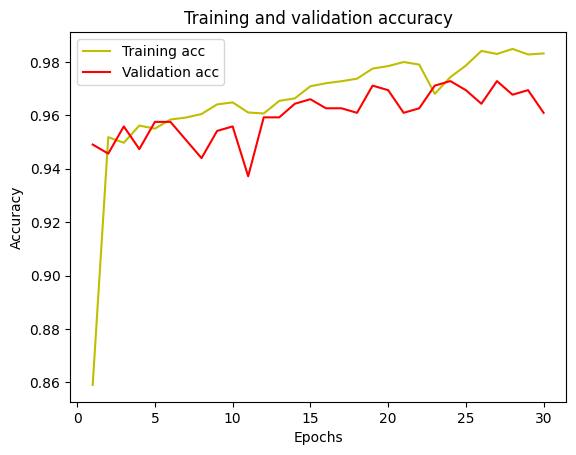

In [11]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step
[[481   1  14   0   0   0]
 [  9 442  20   0   0   0]
 [  5   2 413   0   0   0]
 [  0   7   0 422  62   0]
 [  1   2   0  78 450   1]
 [  0  24   0   0   0 513]]
0.9233118425517476
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       496
           1       0.92      0.94      0.93       471
           2       0.92      0.98      0.95       420
           3       0.84      0.86      0.85       491
           4       0.88      0.85      0.86       532
           5       1.00      0.96      0.98       537

    accuracy                           0.92      2947
   macro avg       0.92      0.93      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

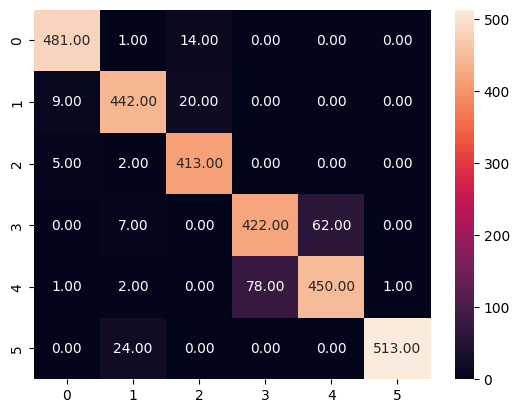

In [12]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn3_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')